In [6]:
%load_ext autoreload
%autoreload 2
print('test')

test


In [153]:
from fin.AccountPerYear import AccountsPerYear, AccountPerYear
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.style.use('dark_background')
figure(figsize=(16, 8), dpi=60)
plt.rcParams["figure.figsize"] = (18,5)

from os import listdir
from os.path import isfile, join
from pathlib import *
import pandas as pd

data_path = Path('./data/2022')

fin_headers = ['date', 'year', 'month', 'credit_or_debet', 'amount', 'credit', 'debet', 'i_number', 'i_name', 'e_number', 'e_name', 'internal_or_external', 'e_type', 'e_official_name', 'description', 'payment_type']

pri_inkomen, pri_boodschappen, pri_fun, pri_overig, pri_abbo, pri_stack, pri_stack_kaakoperatie, huis_inkomen_en_lasten, huis_klussen, huis_huishoudelijk, huis_spaar = [None] * 11
df_pri_inkomen, df_pri_boodschappen, df_pri_fun, df_pri_overig, df_pri_abbo, df_pri_stack, df_pri_stack_kaakoperatie, df_huis_inkomen_en_lasten, df_huis_klussen, df_huis_huishoudelijk, df_huis_spaar = [None] * 11

labels = {
    'NL25KNAB0604860706': 'pri_inkomen',
    'NL60KNAB0604871716': 'pri_boodschappen',
    'NL54KNAB0604873182': 'pri_fun',
    'NL55KNAB0604872291': 'pri_overig',
    'NL08KNAB0604887493': 'pri_abbo',
    '57347285': 'pri_stack',
    '57441905': 'pri_stack_kaakoperatie',
    'NL02KNAB0407458360': 'huis_inkomen_en_lasten',
    'NL45KNAB0407464085': 'huis_klussen',
    'NL13KNAB0407465243': 'huis_huishoudelijk',
    '57857884': 'huis_spaar',
    'NL55INGB0798628839': 'huis_hypotheek',
    'NL06RABO0154599808': 'pri_oud',
    '57673844': 'pri_stack_oud',
    '60010259': 'pri_stack_oud2',
    '58841463': 'pri_stack_cadeautjes',
}

fin_data = AccountsPerYear()
fin_pandas = []
csv_paths = [f for f in listdir(data_path) if isfile(join(data_path, f))]

for i, cvs_path in enumerate(csv_paths):

    path = data_path / cvs_path
    account_number, account_type, year = parse_csv_knab(cvs_path)

    label = labels[account_number]

    s = label.split('_')
    account_name, account_category = (s.pop(0), '_'.join(s))

    df = pd.read_csv(path, skiprows=1, sep=';', decimal=',')
    df['Bedrag'] = df['Bedrag'].astype(float)

    df['Transactiedatum'] = pd.to_datetime(df['Transactiedatum'], dayfirst=True)
    df['Year'] = df['Transactiedatum'].dt.year
    df['Month'] = df['Transactiedatum'].dt.month

    def transform(c):
        c['Credit'] = c['Bedrag'] if c['CreditDebet'] == 'C' else 0
        c['Debet'] = c['Bedrag'] if c['CreditDebet'] == 'D' else 0
        c['RekeningnummerNaam'] = labels[c['Rekeningnummer']] if c['Rekeningnummer'] in labels else '?'
        c['TegenrekeningnummerNaam'] = labels[c['Tegenrekeningnummer']] if c['Tegenrekeningnummer'] in labels else c['Tegenrekeninghouder']
        c['InternalExternal'] = 'I' if c['Tegenrekeningnummer'] in labels else 'E'
        c['e_type'] = ('P' if c['Tegenrekeningnummer'].startswith('NL') else 'S') if c['InternalExternal'] == 'I' else None

        return c

    df = df.apply(transform, axis=1)
    df = df[['Transactiedatum', 'Year', 'Month', 'CreditDebet', 'Bedrag', 'Credit', 'Debet', 'Rekeningnummer', 'RekeningnummerNaam', 'Tegenrekeningnummer', 'TegenrekeningnummerNaam', 'InternalExternal', 'e_type', 'Tegenrekeninghouder', 'Omschrijving', 'Betaalwijze']]
    df = df.set_axis(fin_headers, axis=1)

    fin_pandas.append(df)

    account_info = AccountPerYear(path, df, account_name, account_category, account_number, account_type, year)

    locals().update({f'df_{label}': df})
    fin_data.add_account(account_info)



<Figure size 960x480 with 0 Axes>

In [86]:
print(fin_data.accounts[0])
print(fin_data.accounts[2].get_label())
print(fin_data.get_account('pri_inkomen'))

boodschappen pri NL60KNAB0604871716 2022
pri_inkomen
inkomen pri NL25KNAB0604860706 2022


In [87]:
fin_inf = fin_data.get_account('pri_inkomen')

df = fin_inf.df
df = df.loc[df['credit_or_debet'] == 'C']
df = df.loc[df['internal_or_external'] == 'E']

print(df['e_name'].value_counts())
print(df['e_number'].value_counts())
print(df['payment_type'].value_counts())

df

itbureau                               21
William Loosman                        11
W. J. Loosman en/of J. A. A. Loosma     4
PLUS500CY LTD                           2
J.H. Berkers                            1
Mintos Marketplace AS                   1
D DE BONT                               1
Name: e_name, dtype: int64
NL12KNAB0409998222        21
58841463                   5
58823643                   4
NL14KNAB0506356531         2
59722492                   2
DE97500700100095835500     2
NL60RABO0112807550         1
NL33KNAB0506364046         1
59761161                   1
EE047700771002863435       1
NL75ABNA0599650397         1
Name: e_number, dtype: int64
Ontvangen betaling    41
Name: payment_type, dtype: int64


,date,year,month,credit_or_debet,amount,credit,debet,i_number,i_name,e_number,e_name,internal_or_external,e_type,e_official_name,description,payment_type
1,2022-12-28,2022,12,C,333.00,333.00,0.0,NL25KNAB0604860706,pri_inkomen,NL12KNAB0409998222,itbureau,E,None,itbureau,NaN,Ontvangen betaling
3,2022-12-27,2022,12,C,1600.00,1600.00,0.0,NL25KNAB0604860706,pri_inkomen,NL12KNAB0409998222,itbureau,E,None,itbureau,implantaten,Ontvangen betaling
6,2022-12-19,2022,12,C,500.00,500.00,0.0,NL25KNAB0604860706,pri_inkomen,NL12KNAB0409998222,itbureau,E,None,itbureau,NaN,Ontvangen betaling
12,2022-12-01,2022,12,C,400.00,400.00,0.0,NL25KNAB0604860706,pri_inkomen,NL12KNAB0409998222,itbureau,E,None,itbureau,NaN,Ontvangen betaling
19,2022-11-28,2022,11,C,2099.79,2099.79,0.0,NL25KNAB0604860706,pri_inkomen,NL12KNAB0409998222,itbureau,E,None,itbureau,verloning december,Ontvangen betaling
31,2022-11-07,2022,11,C,200.00,200.00,0.0,NL25KNAB0604860706,pri_inkomen,NL12KNAB0409998222,itbureau,E,None,itbureau,NaN,Ontvangen betaling
37,2022-11-07,2022,11,C,856.85,856.85,0.0,NL25KNAB0604860706,pri_inkomen,NL14KNAB0506356531,W. J. Loosman en/of J. A. A. Loosma,E,None,W. J. Loosman en/of J. A. A. Loosma,NaN,Ontvangen betaling
39,2022-11-07,2022,11,C,2000.00,2000.00,0.0,NL25KNAB0604860706,pri_inkomen,NL12KNAB0409998222,itbureau,E,None,itbureau,verloning november,Ontvangen betaling
44,2022-10-28,2022,10,C,150.00,150.00,0.0,NL25KNAB0604860706,pri_inkomen,NL60RABO0112807550,J.H. Berkers,E,None,J.H. Berkers,Declaratie,Ontvangen betaling
46,2022-10-25,2022,10,C,20.00,20.00,0.0,NL25KNAB0604860706,pri_inkomen,58841463,William Loosman,E,None,William Loosman,teun zwager,Ontvangen betaling


# Inkomen

In [150]:
df = df_pri_inkomen
df = df.loc[df['credit_or_debet'] == 'C']
df.loc[df['e_name'] == 'pri_stack_cadeautjes']

,date,year,month,credit_or_debet,amount,credit,debet,i_number,i_name,e_number,e_name,internal_or_external,e_type,e_official_name,description,payment_type


In [134]:
df = df_pri_inkomen
df = df.loc[df['credit_or_debet'] == 'C']
df = df.loc[df['internal_or_external'] == 'E']

print(df['e_name'].value_counts())

df

itbureau                               21
William Loosman                         6
W. J. Loosman en/of J. A. A. Loosma     4
PLUS500CY LTD                           2
J.H. Berkers                            1
Mintos Marketplace AS                   1
D DE BONT                               1
Name: e_name, dtype: int64


,date,year,month,credit_or_debet,amount,credit,debet,i_number,i_name,e_number,e_name,internal_or_external,e_type,e_official_name,description,payment_type
1,2022-12-28,2022,12,C,333.00,333.00,0.0,NL25KNAB0604860706,pri_inkomen,NL12KNAB0409998222,itbureau,E,None,itbureau,NaN,Ontvangen betaling
3,2022-12-27,2022,12,C,1600.00,1600.00,0.0,NL25KNAB0604860706,pri_inkomen,NL12KNAB0409998222,itbureau,E,None,itbureau,implantaten,Ontvangen betaling
6,2022-12-19,2022,12,C,500.00,500.00,0.0,NL25KNAB0604860706,pri_inkomen,NL12KNAB0409998222,itbureau,E,None,itbureau,NaN,Ontvangen betaling
12,2022-12-01,2022,12,C,400.00,400.00,0.0,NL25KNAB0604860706,pri_inkomen,NL12KNAB0409998222,itbureau,E,None,itbureau,NaN,Ontvangen betaling
19,2022-11-28,2022,11,C,2099.79,2099.79,0.0,NL25KNAB0604860706,pri_inkomen,NL12KNAB0409998222,itbureau,E,None,itbureau,verloning december,Ontvangen betaling
31,2022-11-07,2022,11,C,200.00,200.00,0.0,NL25KNAB0604860706,pri_inkomen,NL12KNAB0409998222,itbureau,E,None,itbureau,NaN,Ontvangen betaling
37,2022-11-07,2022,11,C,856.85,856.85,0.0,NL25KNAB0604860706,pri_inkomen,NL14KNAB0506356531,W. J. Loosman en/of J. A. A. Loosma,E,None,W. J. Loosman en/of J. A. A. Loosma,NaN,Ontvangen betaling
39,2022-11-07,2022,11,C,2000.00,2000.00,0.0,NL25KNAB0604860706,pri_inkomen,NL12KNAB0409998222,itbureau,E,None,itbureau,verloning november,Ontvangen betaling
44,2022-10-28,2022,10,C,150.00,150.00,0.0,NL25KNAB0604860706,pri_inkomen,NL60RABO0112807550,J.H. Berkers,E,None,J.H. Berkers,Declaratie,Ontvangen betaling
49,2022-10-18,2022,10,C,1000.00,1000.00,0.0,NL25KNAB0604860706,pri_inkomen,NL12KNAB0409998222,itbureau,E,None,itbureau,vakantie,Ontvangen betaling


In [133]:
df_per_crediteur = df.groupby('e_name').agg({'credit': ['sum'], 'amount': 'sum'})

labels = df_per_crediteur.index

print(labels)

df_per_crediteur['credit'].iloc[:, 0]

Index(['Firm24 B.V. via PAY.nl',
       'Forum voor Democratie via Mollie  STICHTING MOLLIE PAYMENTS', 'Knab',
       'STICHTING DERDENGELDEN BUCKAROO', 'SenNL Holding B.V.', 'Source',
       'Stichting De Giro', 'W. J. Loosman',
       'W. J. Loosman en/of J. A. A. Loosma', 'huis_inkomen_en_lasten',
       'mintos marketplace AS', 'pri_boodschappen', 'pri_fun', 'pri_overig',
       'pri_stack_kaakoperatie', 'vvz'],
      dtype='object', name='e_name')


e_name
Firm24 B.V. via PAY.nl                                         0.0
Forum voor Democratie via Mollie  STICHTING MOLLIE PAYMENTS    0.0
Knab                                                           0.0
STICHTING DERDENGELDEN BUCKAROO                                0.0
SenNL Holding B.V.                                             0.0
Source                                                         0.0
Stichting De Giro                                              0.0
W. J. Loosman                                                  0.0
W. J. Loosman en/of J. A. A. Loosma                            0.0
huis_inkomen_en_lasten                                         0.0
mintos marketplace AS                                          0.0
pri_boodschappen                                               0.0
pri_fun                                                        0.0
pri_overig                                                     0.0
pri_stack_kaakoperatie                                 

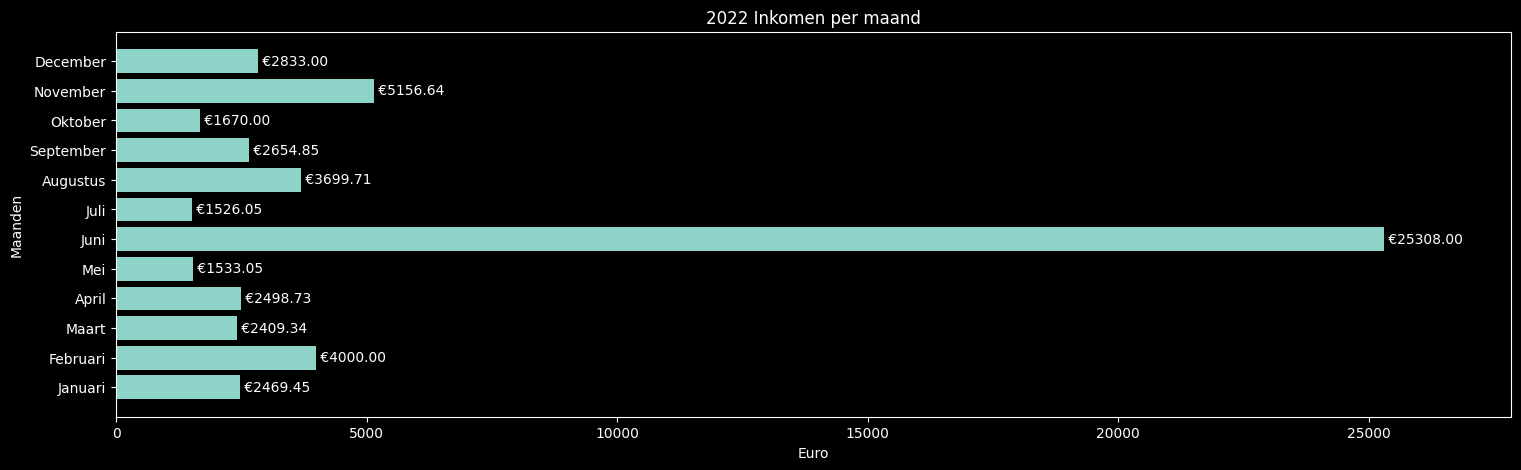

In [88]:
fin_inf : FinAccount = fin_data.get_account('pri_inkomen')

df = fin_inf.df
year = fin_inf.year
df = df.loc[df['credit_or_debet'] == 'C']
df = df.loc[df['internal_or_external'] == 'E']

df_per_maand = df.groupby('month').agg({'credit': ['sum'], 'amount': 'sum'})

labels = df_per_maand.index
values = list(df_per_maand['credit'].iloc[:, 0])

# labels = df['month']
# values = df['credit']

maand_labels = ('Januari', 'Februari', 'Maart', 'April', 'Mei', 'Juni', 'Juli', 'Augustus', 'September', 'Oktober', 'November', 'December')
maand_nummers = (1,2,3,4,5,6,7,8,9,10,11,12)

fig, ax = plt.subplots()

hbars = ax.barh(labels, values, align='center')
ax.set_yticks(maand_nummers, labels=maand_labels)

ax.set_xlabel('Euro')
ax.set_ylabel('Maanden')
ax.set_title(year + ' Inkomen per maand')

# Label with specially formatted floats
# ax.bar_label(hbars, fmt='%.2f')
ax.bar_label(hbars, fmt=' €%.2f')
ax.set_xlim(right=(max(values)*1.1))  # adjust xlim to fit labels

plt.show()

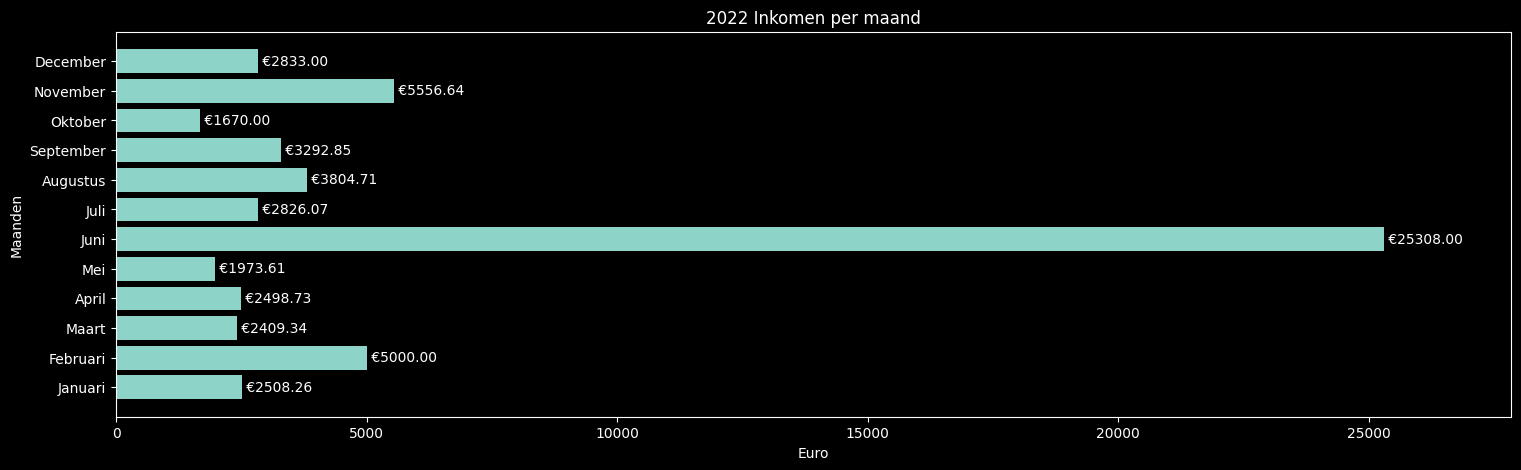

In [89]:
fin_inf : FinAccount = fin_data.get_account('pri_inkomen')

df = fin_inf.df
year = fin_inf.year
df = df.loc[df['credit_or_debet'] == 'C']

df_per_maand = df.groupby('month').agg({'credit': ['sum'], 'amount': 'sum'})

labels = df_per_maand.index
values = list(df_per_maand['amount'].iloc[:, 0])

# labels = df['month']
# values = df['credit']

maand_labels = ('Januari', 'Februari', 'Maart', 'April', 'Mei', 'Juni', 'Juli', 'Augustus', 'September', 'Oktober', 'November', 'December')
maand_nummers = (1,2,3,4,5,6,7,8,9,10,11,12)

fig, ax = plt.subplots()

hbars = ax.barh(labels, values, align='center')
ax.set_yticks(maand_nummers, labels=maand_labels)

ax.set_xlabel('Euro')
ax.set_ylabel('Maanden')
ax.set_title(year + ' Inkomen per maand')

# Label with specially formatted floats
# ax.bar_label(hbars, fmt='%.2f')
ax.bar_label(hbars, fmt=' €%.2f')
ax.set_xlim(right=(max(values)*1.1))  # adjust xlim to fit labels

plt.show()

# Uitgaven

totale uitgaven € 57579.39000000001


amount  \
                                                                         count   
e_name                                             internal_or_external          
pri_overig                                         I                        51   
pri_fun                                            I                        30   
pri_boodschappen                                   I                        25   
Knab                                               E                        12   
W. J. Loosman                                      E                        12   
W. J. Loosman en/of J. A. A. Loosma                E                         8   
huis_inkomen_en_lasten                             I                         6   
SenNL Holding B.V.                                 E                         5   
Source                                             E                         5   
Firm24 B.V. via PAY.nl                             E                         1   
Forum voor Democratie via Mollie  STICHTING MOL... E                         1   
STICHTING DERDENGELDEN BUCKAROO                    E                         1   
Stichting De Giro                                  E                         1   
mintos marketplace AS                              E                         1   
vvz                                                E                         1   

                                                                                   \
                                                                              sum   
e_name                                             internal_or_external             
pri_overig                                         I                     11171.56   
pri_fun                                            I                      4076.58   
pri_boodschappen                                   I                      4191.02   
Knab                                               E                        60.00   
W. J. Loosman                                      E                      3649.98   
W. J. Loosman en/of J. A. A. Loosma                E                     25856.85   
huis_inkomen_en_lasten                             I                      2750.00   
SenNL Holding B.V.                                 E                      4284.25   
Source                                             E                      1160.00   
Firm24 B.V. via PAY.nl                             E                         0.01   
Forum voor Democratie via Mollie  STICHTING MOL... E                        25.00   
STICHTING DERDENGELDEN BUCKAROO                    E                         7.00   
Stichting De Giro                                  E                         0.01   
mintos marketplace AS                              E                         0.01   
vvz                                                E                       347.12   

                                                                                      \
                                                                           per_month   
e_name                                             internal_or_external                
pri_overig                                         I                      930.963333   
pri_fun                                            I                      339.715000   
pri_boodschappen                                   I                      349.251667   
Knab                                               E                        5.000000   
W. J. Loosman                                      E                      304.165000   
W. J. Loosman en/of J. A. A. Loosma                E                     2154.737500   
huis_inkomen_en_lasten                             I                      229.166667   
SenNL Holding B.V.                                 E                      357.020833   
Source                                             E                       96.666667   
Firm24 B

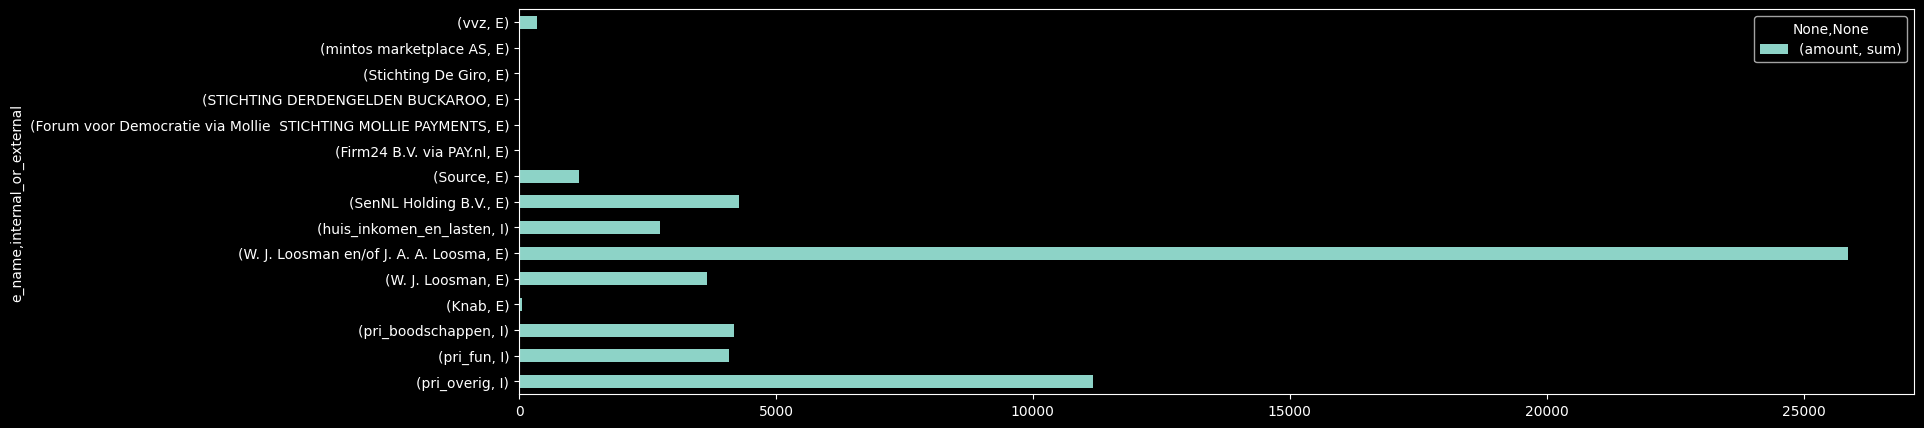

In [131]:
df = df_pri_inkomen
df = df.loc[df['credit_or_debet'] == 'D']
df = df.loc[df['e_type'] != 'S']

df_per_category = df.groupby(['e_name', 'internal_or_external']) \
                             .agg({'amount': ['count',  'sum', ('per_month', lambda v: v.sum() / 12), 'mean', 'min', 'max']}) \
                             .sort_values(by=[('amount', 'count')], ascending=False)
df_per_category[[('amount','sum')]].plot.barh()

print("totale uitgaven €", sum(df_per_category[('amount','sum')]))

df_per_category

In [132]:
df = df_pri_inkomen
df = df.loc[df['credit_or_debet'] == 'D']

print(df['e_name'].value_counts())

df

pri_overig                                                     51
pri_fun                                                        30
pri_boodschappen                                               25
Knab                                                           12
W. J. Loosman                                                  12
W. J. Loosman en/of J. A. A. Loosma                             8
huis_inkomen_en_lasten                                          6
SenNL Holding B.V.                                              5
Source                                                          5
pri_stack_kaakoperatie                                          2
Firm24 B.V. via PAY.nl                                          1
vvz                                                             1
mintos marketplace AS                                           1
STICHTING DERDENGELDEN BUCKAROO                                 1
Forum voor Democratie via Mollie  STICHTING MOLLIE PAYMENTS     1
Stichting 

,date,year,month,credit_or_debet,amount,credit,debet,i_number,i_name,e_number,e_name,internal_or_external,e_type,e_official_name,description,payment_type
0,2022-12-28,2022,12,D,332.00,0.0,332.00,NL25KNAB0604860706,pri_inkomen,NL55KNAB0604872291,pri_overig,I,P,W. J. Loosman,NaN,Overboeking
2,2022-12-27,2022,12,D,1600.00,0.0,1600.00,NL25KNAB0604860706,pri_inkomen,57441905,pri_stack_kaakoperatie,I,S,W. J. Loosman,reservering,Overboeking
4,2022-12-23,2022,12,D,100.00,0.0,100.00,NL25KNAB0604860706,pri_inkomen,NL60KNAB0604871716,pri_boodschappen,I,P,W. J. Loosman,NaN,Overboeking
5,2022-12-19,2022,12,D,175.00,0.0,175.00,NL25KNAB0604860706,pri_inkomen,NL55KNAB0604872291,pri_overig,I,P,W. J. Loosman,zalmpjes kesrt,Overboeking
7,2022-12-14,2022,12,D,15.00,0.0,15.00,NL25KNAB0604860706,pri_inkomen,NL55KNAB0604872291,pri_overig,I,P,W. J. Loosman,NaN,Overboeking
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,2022-01-04,2022,1,D,333.33,0.0,333.33,NL25KNAB0604860706,pri_inkomen,58823724,W. J. Loosman,E,None,W. J. Loosman,NaN,Overboeking
210,2022-01-04,2022,1,D,109.94,0.0,109.94,NL25KNAB0604860706,pri_inkomen,NL54KNAB0604873182,pri_fun,I,P,W. J. Loosman,NaN,Overboeking
211,2022-01-04,2022,1,D,16.59,0.0,16.59,NL25KNAB0604860706,pri_inkomen,NL60KNAB0604871716,pri_boodschappen,I,P,W. J. Loosman,NaN,Overboeking
213,2022-01-03,2022,1,D,130.00,0.0,130.00,NL25KNAB0604860706,pri_inkomen,NL60KNAB0604871716,pri_boodschappen,I,P,W. J. Loosman,NaN,Overboeking


In [15]:
df_per_account = df.groupby('i_name').agg({'amount': 'sum'})


labels = df_per_account.index

print(labels)

values = list(df_per_account['amount'])
values

Index(['pri_inkomen'], dtype='object', name='i_name')


[59579.39]

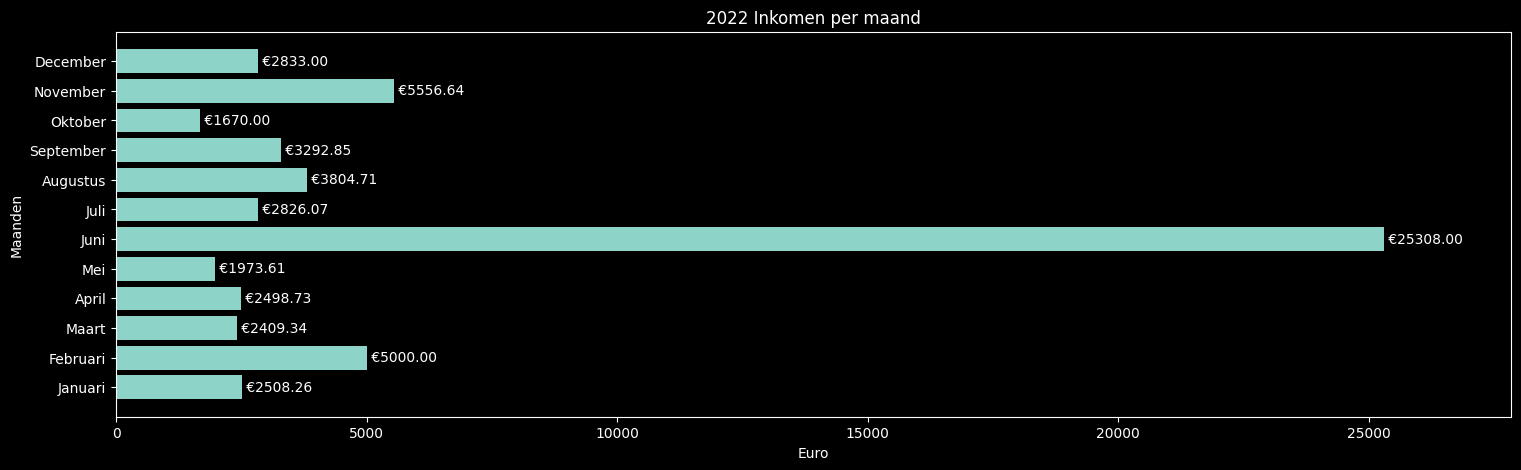

In [90]:
df_per_maand = df.groupby('month').agg({'credit': ['sum'], 'amount': 'sum'})

labels = df_per_maand.index
values = list(df_per_maand['amount'].iloc[:, 0])

# labels = df['month']
# values = df['credit']

maand_labels = ('Januari', 'Februari', 'Maart', 'April', 'Mei', 'Juni', 'Juli', 'Augustus', 'September', 'Oktober', 'November', 'December')
maand_nummers = (1,2,3,4,5,6,7,8,9,10,11,12)

fig, ax = plt.subplots()

hbars = ax.barh(labels, values, align='center')
ax.set_yticks(maand_nummers, labels=maand_labels)

ax.set_xlabel('Euro')
ax.set_ylabel('Maanden')
ax.set_title(year + ' Inkomen per maand')

# Label with specially formatted floats
# ax.bar_label(hbars, fmt='%.2f')
ax.bar_label(hbars, fmt=' €%.2f')
ax.set_xlim(right=(max(values)*1.1))  # adjust xlim to fit labels

plt.show()

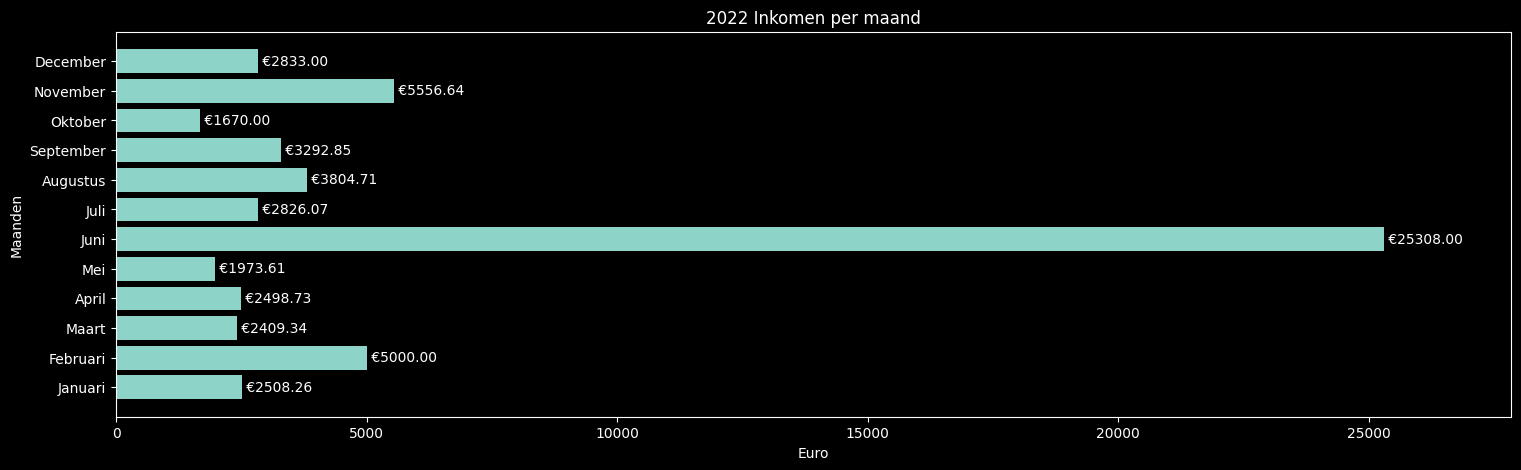

In [91]:
df = df_pri_inkomen
df = df.loc[df['credit_or_debet'] == 'C']

df_per_maand = df.groupby('month').agg({'credit': ['sum'], 'amount': 'sum'})

labels = df_per_maand.index
values = list(df_per_maand['amount'].iloc[:, 0])

# labels = df['month']
# values = df['credit']

maand_labels = ('Januari', 'Februari', 'Maart', 'April', 'Mei', 'Juni', 'Juli', 'Augustus', 'September', 'Oktober', 'November', 'December')
maand_nummers = (1,2,3,4,5,6,7,8,9,10,11,12)

fig, ax = plt.subplots()

hbars = ax.barh(labels, values, align='center')
ax.set_yticks(maand_nummers, labels=maand_labels)

ax.set_xlabel('Euro')
ax.set_ylabel('Maanden')
ax.set_title(year + ' Inkomen per maand')

# Label with specially formatted floats
# ax.bar_label(hbars, fmt='%.2f')
ax.bar_label(hbars, fmt=' €%.2f')
ax.set_xlim(right=(max(values)*1.1))  # adjust xlim to fit labels

plt.show()

# Uitgaven

amount                               
                                  sum         mean      min      max
month e_name                                                        
1     huis_inkomen_en_lasten   350.00   350.000000   350.00   350.00
      pri_boodschappen         524.26   131.065000    16.59   277.67
      pri_fun                  269.23   134.615000   109.94   159.29
      pri_overig               404.30   101.075000    15.00   189.30
2     huis_inkomen_en_lasten  1350.00   675.000000   350.00  1000.00
      pri_boodschappen         294.93   294.930000   294.93   294.93
      pri_fun                  217.90   108.950000    50.00   167.90
      pri_overig              2270.00   454.000000    70.00  1000.00
3     huis_inkomen_en_lasten   350.00   350.000000   350.00   350.00
      pri_boodschappen         382.13   191.065000   100.00   282.13
      pri_fun                  140.68   140.680000   140.68   140.68
      pri_overig              1448.41   289.682000    70.00   700.00
4     huis_inkomen_en_lasten   350.00   350.000000   350.00   350.00
      pri_boodschappen         288.83   288.830000   288.83   288.83
      pri_fun                  160.68    80.340000    20.00   140.68
      pri_overig               185.53    61.843333    40.00    85.54
5     huis_inkomen_en_lasten   350.00   350.000000   350.00   350.00
      pri_boodschappen         348.71   174.355000    50.00   298.71
      pri_fun                  326.77    54.461667    10.00   156.77
      pri_overig               299.24    74.810000     5.00   244.24
6     pri_boodschappen         359.38   119.793333    30.00   269.38
      pri_fun                  120.52   120.520000   120.52   120.52
      pri_overig               510.00   170.000000    10.00   450.00
7     pri_boodschappen         345.80   172.900000   100.00   245.80
      pri_fun                  623.50   207.833333   123.50   350.00
      pri_overig               299.90   149.950000    99.90   200.00
8     pri_boodschappen         519.66   173.220000    50.00   269.66
      pri_fun                  149.45    74.725000    20.00   129.45
      pri_overig              2243.75  1121.875000   243.75  2000.00
9     pri_boodschappen         373.22   186.610000   100.00   273.22
      pri_fun                  843.14   421.570000    18.00   825.14
      pri_overig               581.72   116.344000    18.00   233.72
10    pri_boodschappen          65.00    32.500000    15.00    50.00
      pri_fun                  900.00   450.000000   100.00   800.00
      pri_overig               767.00   191.750000    17.00   500.00
11    pri_boodschappen         589.10   294.550000   250.44   338.66
      pri_fun                  324.71    46.387143     5.00   126.61
      pri_overig              1239.71   177.101429     3.00   680.00
      pri_stack_kaakoperatie   400.00   400.000000   400.00   400.00
12    pri_boodschappen         100.00   100.000000   100.00   100.00
      pri_overig               922.00   131.714286    15.00   332.00
      pri_stack_kaakoperatie  1600.00  1600.000000  1600.00  1600.00

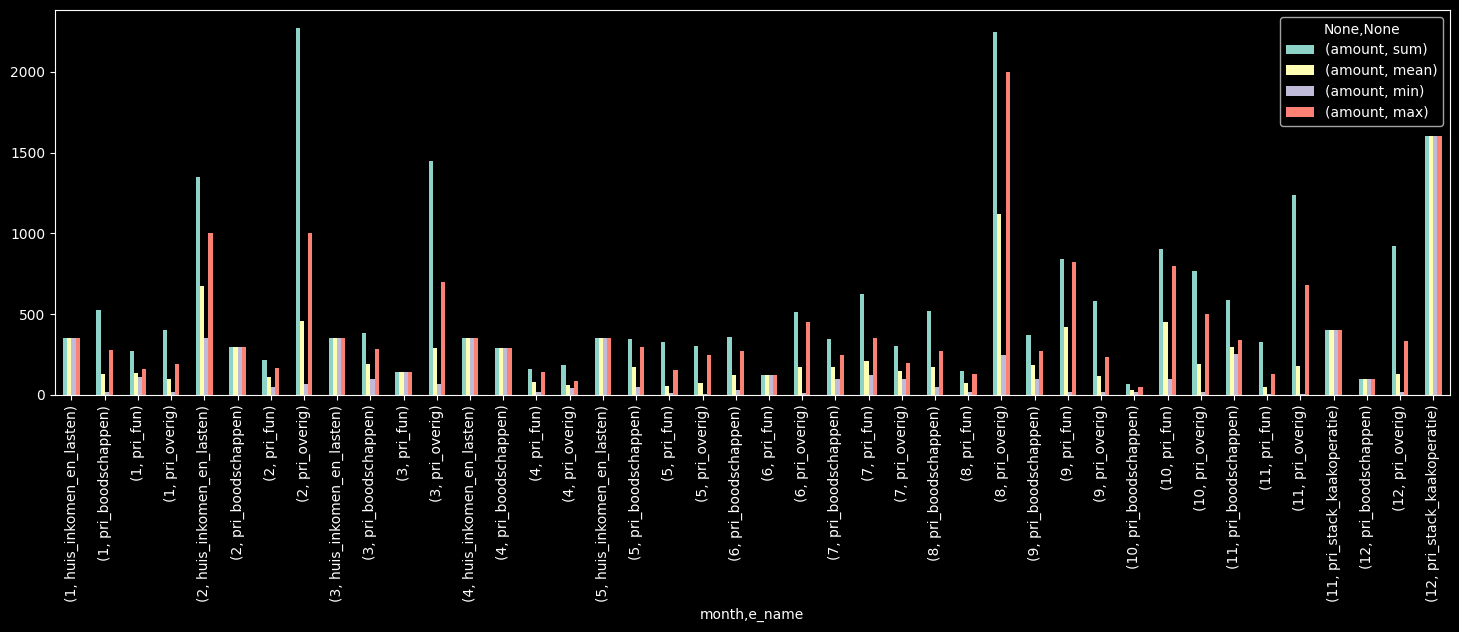

In [103]:
df = df_pri_inkomen
df = df.loc[df['credit_or_debet'] == 'D']
df = df.loc[df['internal_or_external'] == 'I']
df = df.loc[df['e_type'].isin(['P', 'S'])]

df_per_maand = df.groupby(['month', 'e_name']).agg({'amount': ['sum', 'mean', 'min', 'max']})

df_per_maand.plot.bar()
df_per_maand

amount                                         
                             sum   per_month         mean    min      max
e_name                                                                   
huis_inkomen_en_lasten   2750.00  229.166667   458.333333  350.0  1000.00
pri_boodschappen         4191.02  349.251667   167.640800   15.0   338.66
pri_fun                  4076.58  339.715000   135.886000    5.0   825.14
pri_overig              11171.56  930.963333   219.050196    3.0  2000.00
pri_stack_kaakoperatie   2000.00  166.666667  1000.000000  400.0  1600.00

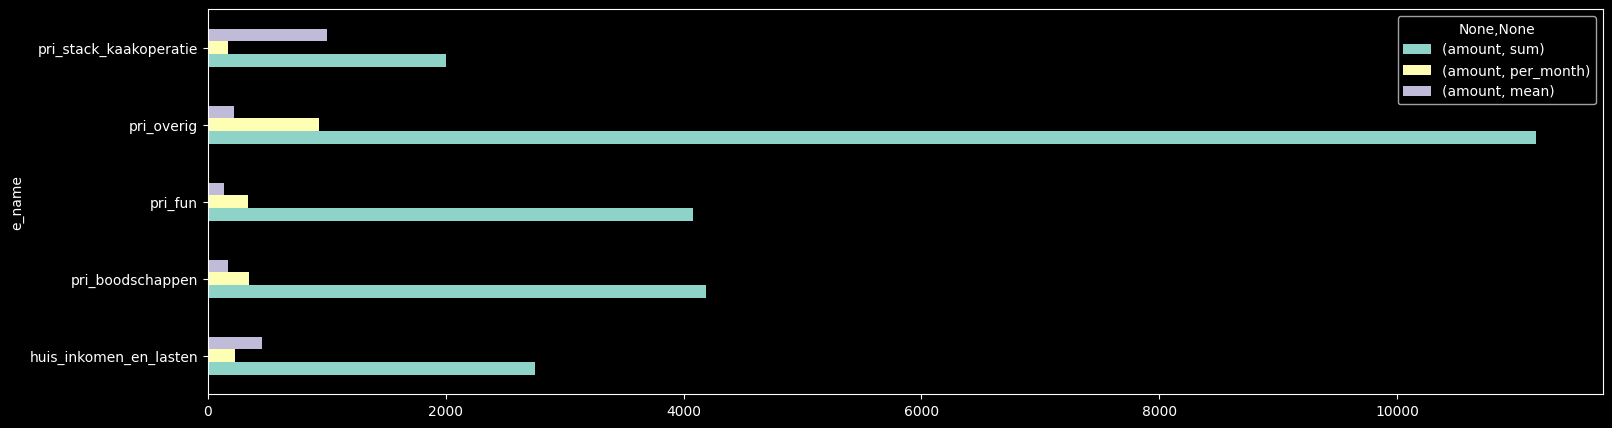

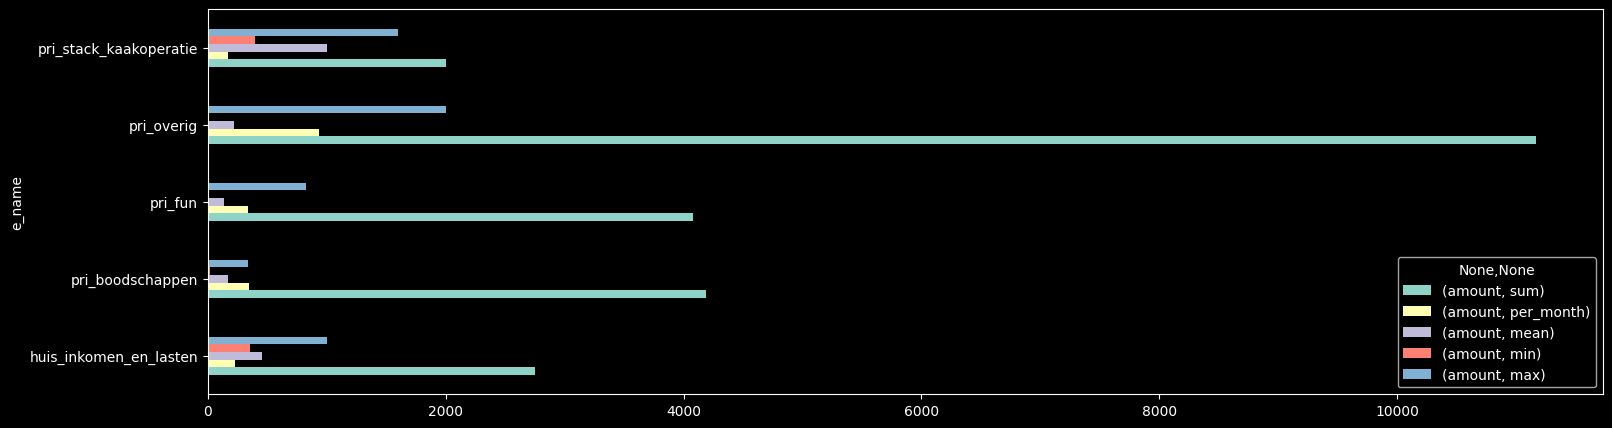

In [104]:
df.groupby(['e_name']).agg({'amount': ['sum', ('per_month', lambda v: v.sum() / 12), 'mean']}).plot.barh()

df_per_category = df.groupby(['e_name']).agg({'amount': ['sum', ('per_month', lambda v: v.sum() / 12), 'mean', 'min', 'max']})
df_per_category.plot.barh()
df_per_category

In [105]:
df

,date,year,month,credit_or_debet,amount,credit,debet,i_number,i_name,e_number,e_name,internal_or_external,e_type,e_official_name,description,payment_type
0,2022-12-28,2022,12,D,332.00,0.0,332.00,NL25KNAB0604860706,pri_inkomen,NL55KNAB0604872291,pri_overig,I,P,W. J. Loosman,NaN,Overboeking
2,2022-12-27,2022,12,D,1600.00,0.0,1600.00,NL25KNAB0604860706,pri_inkomen,57441905,pri_stack_kaakoperatie,I,S,W. J. Loosman,reservering,Overboeking
4,2022-12-23,2022,12,D,100.00,0.0,100.00,NL25KNAB0604860706,pri_inkomen,NL60KNAB0604871716,pri_boodschappen,I,P,W. J. Loosman,NaN,Overboeking
5,2022-12-19,2022,12,D,175.00,0.0,175.00,NL25KNAB0604860706,pri_inkomen,NL55KNAB0604872291,pri_overig,I,P,W. J. Loosman,zalmpjes kesrt,Overboeking
7,2022-12-14,2022,12,D,15.00,0.0,15.00,NL25KNAB0604860706,pri_inkomen,NL55KNAB0604872291,pri_overig,I,P,W. J. Loosman,NaN,Overboeking
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,2022-01-24,2022,1,D,100.00,0.0,100.00,NL25KNAB0604860706,pri_inkomen,NL55KNAB0604872291,pri_overig,I,P,W. J. Loosman,NaN,Overboeking
204,2022-01-20,2022,1,D,100.00,0.0,100.00,NL25KNAB0604860706,pri_inkomen,NL60KNAB0604871716,pri_boodschappen,I,P,W. J. Loosman,kaakoperatievoer,Overboeking
210,2022-01-04,2022,1,D,109.94,0.0,109.94,NL25KNAB0604860706,pri_inkomen,NL54KNAB0604873182,pri_fun,I,P,W. J. Loosman,NaN,Overboeking
211,2022-01-04,2022,1,D,16.59,0.0,16.59,NL25KNAB0604860706,pri_inkomen,NL60KNAB0604871716,pri_boodschappen,I,P,W. J. Loosman,NaN,Overboeking


## abbo

In [106]:
df = df_pri_abbo
df = df.loc[df['credit_or_debet'] == 'D']

print(df['e_name'].value_counts())

df

KPN - Mobiel                           12
D.S.W. Zorgverzekeraar                 11
DUO Hoofdrekening                       6
SIMYO                                   6
Transip B.V.                            4
STICHTING DERDENGELDEN BUCKAROO         2
Dienst Uitvoering Onderwijs             2
SPOTIFY  SpotifyNL                      2
Smart Fit Nieuwegein B.V.               1
Eversport GmbH                          1
Smart Fit Nieuwegein BV by Buckaroo     1
GS Magenta B.V. via Mollie              1
Name: e_name, dtype: int64


,date,year,month,credit_or_debet,amount,credit,debet,i_number,i_name,e_number,e_name,internal_or_external,e_type,e_official_name,description,payment_type
0,2022-12-27,2022,12,D,200.71,0.0,200.71,NL08KNAB0604887493,pri_abbo,NL45INGB0705001903,DUO Hoofdrekening,E,None,DUO Hoofdrekening,3216213915221295 DUO langlopende studieschuld ...,Periodieke incasso
1,2022-12-09,2022,12,D,26.89,0.0,26.89,NL08KNAB0604887493,pri_abbo,NL83INGB0000325513,KPN - Mobiel,E,None,KPN - Mobiel,"Factuur 02-12-2022, klantnummer 20198828494, k...",Periodieke incasso
2,2022-11-25,2022,11,D,37.50,0.0,37.50,NL08KNAB0604887493,pri_abbo,NL11RABO0343685310,D.S.W. Zorgverzekeraar,E,None,D.S.W. Zorgverzekeraar,Kenmerk: 2207025045112271 / Omschrijving: Gesp...,Periodieke incasso
3,2022-11-25,2022,11,D,200.71,0.0,200.71,NL08KNAB0604887493,pri_abbo,NL45INGB0705001903,DUO Hoofdrekening,E,None,DUO Hoofdrekening,0216213915221195 DUO langlopende studieschuld ...,Periodieke incasso
4,2022-11-09,2022,11,D,26.89,0.0,26.89,NL08KNAB0604887493,pri_abbo,NL83INGB0000325513,KPN - Mobiel,E,None,KPN - Mobiel,"Factuur 02-11-2022, klantnummer 20198828494, k...",Periodieke incasso
5,2022-10-25,2022,10,D,37.50,0.0,37.50,NL08KNAB0604887493,pri_abbo,NL11RABO0343685310,D.S.W. Zorgverzekeraar,E,None,D.S.W. Zorgverzekeraar,Kenmerk: 1207025045102271 / Omschrijving: Gesp...,Periodieke incasso
6,2022-10-25,2022,10,D,200.71,0.0,200.71,NL08KNAB0604887493,pri_abbo,NL45INGB0705001903,DUO Hoofdrekening,E,None,DUO Hoofdrekening,8216213915221095 DUO langlopende studieschuld ...,Periodieke incasso
7,2022-10-10,2022,10,D,26.89,0.0,26.89,NL08KNAB0604887493,pri_abbo,NL83INGB0000325513,KPN - Mobiel,E,None,KPN - Mobiel,"Factuur 03-10-2022, klantnummer 20198828494, k...",Periodieke incasso
8,2022-09-26,2022,9,D,37.50,0.0,37.50,NL08KNAB0604887493,pri_abbo,NL11RABO0343685310,D.S.W. Zorgverzekeraar,E,None,D.S.W. Zorgverzekeraar,Kenmerk: 8207025045092271 / Omschrijving: Gesp...,Periodieke incasso
9,2022-09-26,2022,9,D,200.71,0.0,200.71,NL08KNAB0604887493,pri_abbo,NL45INGB0705001903,DUO Hoofdrekening,E,None,DUO Hoofdrekening,7216213915220995 DUO langlopende studieschuld ...,Periodieke incasso


amount                                  \
                                         sum   per_month        mean     min   
e_name                                                                         
D.S.W. Zorgverzekeraar               2168.88  180.740000  197.170909   37.50   
DUO Hoofdrekening                    1204.26  100.355000  200.710000  200.71   
Dienst Uitvoering Onderwijs          1199.38   99.948333  599.690000  397.46   
Eversport GmbH                         15.00    1.250000   15.000000   15.00   
GS Magenta B.V. via Mollie             33.33    2.777500   33.330000   33.33   
KPN - Mobiel                          298.17   24.847500   24.847500   18.32   
SIMYO                                  39.94    3.328333    6.656667    4.20   
SPOTIFY  SpotifyNL                     19.98    1.665000    9.990000    9.99   
STICHTING DERDENGELDEN BUCKAROO        53.28    4.440000   26.640000   26.64   
Smart Fit Nieuwegein B.V.              26.64    2.220000   26.640000   26.64   
Smart Fit Nieuwegein BV by Buckaroo    61.64    5.136667   61.640000   61.64   
Transip B.V.                           70.76    5.896667   17.690000    9.67   

                                              
                                         max  
e_name                                        
D.S.W. Zorgverzekeraar               1793.88  
DUO Hoofdrekening                     200.71  
Dienst Uitvoering Onderwijs           801.92  
Eversport GmbH                         15.00  
GS Magenta B.V. via Mollie             33.33  
KPN - Mobiel                           33.31  
SIMYO                                   7.51  
SPOTIFY  SpotifyNL                      9.99  
STICHTING DERDENGELDEN BUCKAROO        26.64  
Smart Fit Nieuwegein B.V.              26.64  
Smart Fit Nieuwegein BV by Buckaroo    61.64  
Transip B.V.                           32.07

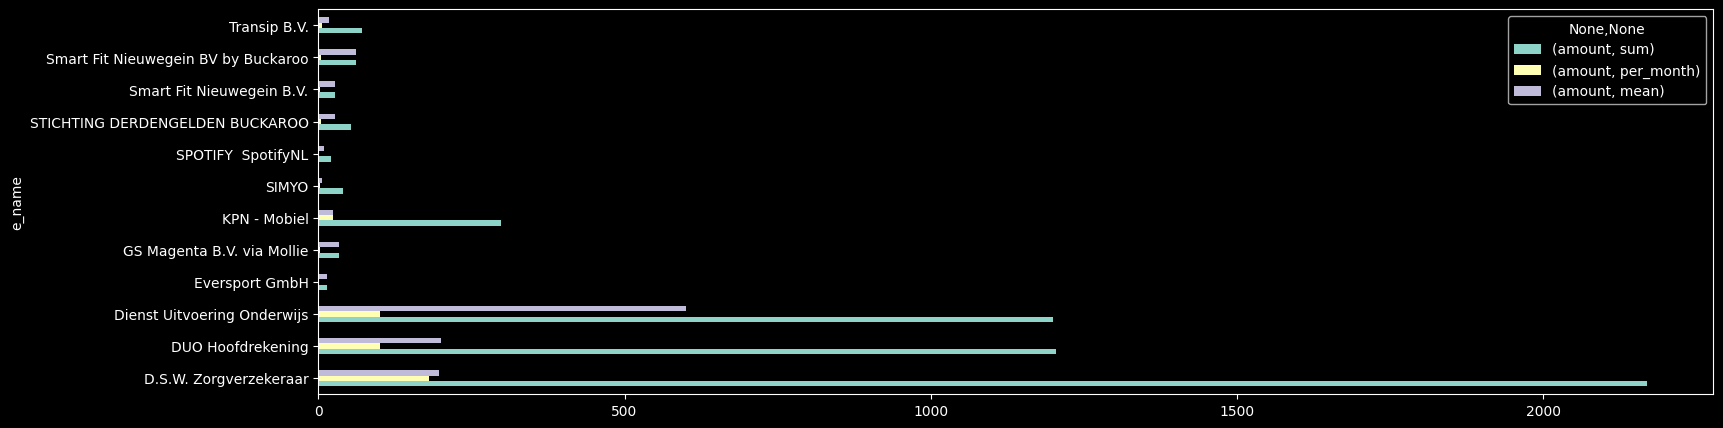

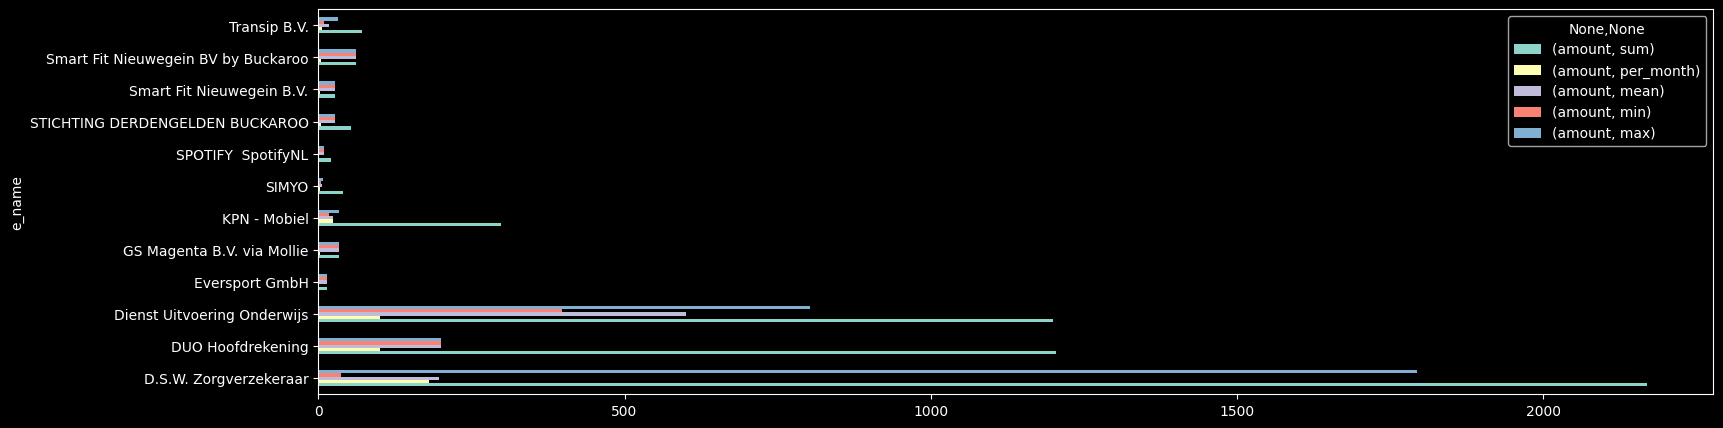

In [107]:
df.groupby(['e_name']).agg({'amount': ['sum', ('per_month', lambda v: v.sum() / 12), 'mean']}).plot.barh()

df_per_category = df.groupby(['e_name']).agg({'amount': ['sum', ('per_month', lambda v: v.sum() / 12), 'mean', 'min', 'max']})
df_per_category.plot.barh()
df_per_category

## Sauna

In [23]:
# df = df_pri_overig
df = df_pri_fun

search_term = 'thermen'

search = df[df['e_official_name'].str.contains(search_term, na=False, case=False)]
search2 = df[df['description'].str.contains(search_term, na=False, case=False)]

c = ['year', 'month','amount', 'e_official_name', 'description']
print('search1')
print(search[c])
print('search2')
print(search2[c])

df

search1
     year  month  amount                      e_official_name  \
1    2022     12    71.0      Thermen Barendrecht by Buckaroo   
181  2022      4   127.9  Thermen Soesterberg B.V. via Mollie   
188  2022      4    97.9  Thermen Soesterberg B.V. via Mollie   

                         description  
1          Thermen Barendrecht 31524  
181  865760 - Thermen Soesterberg NL  
188  858273 - Thermen Soesterberg NL  
search2
     year  month  amount                      e_official_name  \
1    2022     12    71.0      Thermen Barendrecht by Buckaroo   
181  2022      4   127.9  Thermen Soesterberg B.V. via Mollie   
188  2022      4    97.9  Thermen Soesterberg B.V. via Mollie   

                         description  
1          Thermen Barendrecht 31524  
181  865760 - Thermen Soesterberg NL  
188  858273 - Thermen Soesterberg NL  


,date,year,month,credit_or_debet,amount,credit,debet,i_number,i_name,e_number,e_name,internal_or_external,e_type,e_official_name,description,payment_type
0,2022-12-17,2022,12,D,15.00,0.00,15.00,NL54KNAB0604873182,pri_fun,,SumUp *Tran Loempia,E,None,SumUp *Tran Loempia,Urk 17-12-2022 11:15 Pas: 0703,Betaalautomaat
1,2022-12-13,2022,12,D,71.00,0.00,71.00,NL54KNAB0604873182,pri_fun,NL56DEUT0265186420,Thermen Barendrecht by Buckaroo,E,None,Thermen Barendrecht by Buckaroo,Thermen Barendrecht 31524,iDEAL
2,2022-12-03,2022,12,D,17.50,0.00,17.50,NL54KNAB0604873182,pri_fun,,SumUp *Tran Loempia,E,None,SumUp *Tran Loempia,Urk 03-12-2022 10:17 Pas: 0703,Betaalautomaat
3,2022-11-28,2022,11,C,113.10,113.10,0.00,NL54KNAB0604873182,pri_fun,NL25KNAB0604860706,pri_inkomen,I,P,William Loosman,NaN,Ontvangen betaling
4,2022-11-26,2022,11,D,14.20,0.00,14.20,NL54KNAB0604873182,pri_fun,,Poeliersbedrijf Verh,E,None,Poeliersbedrijf Verh,ERMELO 26-11-2022 09:46 Pas: 0703,Betaalautomaat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,2022-01-21,2022,1,D,6.60,0.00,6.60,NL54KNAB0604873182,pri_fun,,Mcdonalds Blokhoeve,E,None,Mcdonalds Blokhoeve,NIEUWEGEIN 21-01-2022 20:36 Pas: 0703,Betaalautomaat
212,2022-01-17,2022,1,D,18.50,0.00,18.50,NL54KNAB0604873182,pri_fun,,Maximasnack,E,None,Maximasnack,URK 17-01-2022 17:39 Pas: 0703,Betaalautomaat
213,2022-01-17,2022,1,D,20.95,0.00,20.95,NL54KNAB0604873182,pri_fun,NL31ABNA0494688556,Thuisbezorgd.nl via Takeaway.com,E,None,Thuisbezorgd.nl via Takeaway.com,bestelling Spare Rib Express via,iDEAL
214,2022-01-15,2022,1,D,15.69,0.00,15.69,NL54KNAB0604873182,pri_fun,,Albert Heijn 1327,E,None,Albert Heijn 1327,NIEUWEGEIN 15-01-2022 15:44 Pas: 0703,Betaalautomaat


# Overig

In [66]:
df = df_pri_overig
df = df.loc[df['credit_or_debet'] == 'D']

print(df['e_name'].value_counts())

df

bol.com b.v.                           17
UMC UTRECHT                            11
INT CARD SERVICES                      10
ABN AMRO Bank NV                        9
Sligro ZB 5060                          9
                                       ..
De Bijenkorf                            1
Uniqlo Europe Ltd Dutc                  1
Kruidvat 1058                           1
Nederlandse Brandwonden Stichting v     1
Jumbo Nieuwegein Gal                    1
Name: e_name, Length: 115, dtype: int64


,date,year,month,credit_or_debet,amount,credit,debet,i_number,i_name,e_number,e_name,internal_or_external,e_type,e_official_name,description,payment_type
0,2022-12-28,2022,12,D,9.76,0.0,9.76,NL55KNAB0604872291,pri_overig,,Jumbo Nieuwegein Wal,E,None,Jumbo Nieuwegein Wal,NIEUWEGEIN 28-12-2022 13:32 Pas: 1155,Betaalautomaat
1,2022-12-28,2022,12,D,332.00,0.0,332.00,NL55KNAB0604872291,pri_overig,NL56INGB0705005100,CJIB Verkeersboetes,E,None,CJIB Verkeersboetes,Betaling via iDEAL QR-code,iDEAL
3,2022-12-27,2022,12,D,7.95,0.0,7.95,NL55KNAB0604872291,pri_overig,NL27INGB0000026500,bol.com b.v.,E,None,bol.com b.v.,bol.com ref 1541147309 bol.com,iDEAL
4,2022-12-22,2022,12,D,10.99,0.0,10.99,NL55KNAB0604872291,pri_overig,,Etos 7469,E,None,Etos 7469,NIEUWEGEIN 22-12-2022 12:19 Pas: 0596,Betaalautomaat
7,2022-12-19,2022,12,D,175.00,0.0,175.00,NL55KNAB0604872291,pri_overig,NL10INGB0005300114,ING Bank NV Betaalverzoek,E,None,ING Bank NV Betaalverzoek,Etentje ING Betaalverzoek,iDEAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,2022-01-05,2022,1,D,27.00,0.0,27.00,NL55KNAB0604872291,pri_overig,NL47ABNA0612205029,VC Coaching B.V. via Stichting PayP,E,None,VC Coaching B.V. via Stichting PayP,Van Bitch Naar Baas Boek,iDEAL
302,2022-01-05,2022,1,D,32.01,0.0,32.01,NL55KNAB0604872291,pri_overig,,Jumbo Nieuwegein Gal,E,None,Jumbo Nieuwegein Gal,NIEUWEGEIN 05-01-2022 15:16 Pas: 0596,Betaalautomaat
303,2022-01-05,2022,1,D,5.78,0.0,5.78,NL55KNAB0604872291,pri_overig,,Albert Heijn 1327,E,None,Albert Heijn 1327,NIEUWEGEIN 05-01-2022 12:09 Pas: 0596,Betaalautomaat
305,2022-01-03,2022,1,D,66.80,0.0,66.80,NL55KNAB0604872291,pri_overig,NL23ABNA0818769483,INT CARD SERVICES,E,None,INT CARD SERVICES,Incasso dec 2021 betreffende uw creditcard ICS...,Periodieke incasso


Cadeautjes

In [152]:
fd : FinAccount = fin_data.get_account("pri_overig")
df = fd.df
df_cad = df.loc[df['e_name'] == 'pri_stack_cadeautjes']

t = sum(df_cad['amount'])

print(f"Uitgaven {fd.get_label()} {fd.year}")
print(f"Uitgegeven aan cadeautjes: €{t}")

df_cad

Uitgaven pri_overig 2022
Uitgegeven aan cadeautjes: €392.62


,date,year,month,credit_or_debet,amount,credit,debet,i_number,i_name,e_number,e_name,internal_or_external,e_type,e_official_name,description,payment_type
10,2022-12-16,2022,12,C,20.00,20.00,0.0,NL55KNAB0604872291,pri_overig,58841463,pri_stack_cadeautjes,I,S,William Loosman,kraam nadine,Ontvangen betaling
50,2022-11-09,2022,11,C,20.00,20.00,0.0,NL55KNAB0604872291,pri_overig,58841463,pri_stack_cadeautjes,I,S,William Loosman,afscheidscadeautje receptie enexis,Ontvangen betaling
96,2022-09-30,2022,9,C,20.00,20.00,0.0,NL55KNAB0604872291,pri_overig,58841463,pri_stack_cadeautjes,I,S,William Loosman,NaN,Ontvangen betaling
109,2022-09-13,2022,9,C,30.00,30.00,0.0,NL55KNAB0604872291,pri_overig,58841463,pri_stack_cadeautjes,I,S,William Loosman,NaN,Ontvangen betaling
117,2022-09-07,2022,9,C,15.00,15.00,0.0,NL55KNAB0604872291,pri_overig,58841463,pri_stack_cadeautjes,I,S,William Loosman,anna huisgenoot,Ontvangen betaling
138,2022-07-25,2022,7,C,9.20,9.20,0.0,NL55KNAB0604872291,pri_overig,58841463,pri_stack_cadeautjes,I,S,William Loosman,NaN,Ontvangen betaling
146,2022-07-11,2022,7,C,26.65,26.65,0.0,NL55KNAB0604872291,pri_overig,58841463,pri_stack_cadeautjes,I,S,William Loosman,NaN,Ontvangen betaling
174,2022-06-10,2022,6,C,59.99,59.99,0.0,NL55KNAB0604872291,pri_overig,58841463,pri_stack_cadeautjes,I,S,William Loosman,NaN,Ontvangen betaling
185,2022-05-23,2022,5,C,58.99,58.99,0.0,NL55KNAB0604872291,pri_overig,58841463,pri_stack_cadeautjes,I,S,William Loosman,cadeau nigel wiskhey,Ontvangen betaling
191,2022-05-11,2022,5,C,50.00,50.00,0.0,NL55KNAB0604872291,pri_overig,58841463,pri_stack_cadeautjes,I,S,William Loosman,NaN,Ontvangen betaling


amount                         \
                                     count       sum    per_month   
e_name                                                              
itbureau                                21  28041.50  2336.791667   
William Loosman                         11  23406.62  1950.551667   
pri_stack_oud2                           6   1143.00    95.250000   
W. J. Loosman en/of J. A. A. Loosma      4   2113.70   176.141667   
PLUS500CY LTD                            2   1099.37    91.614167   
huis_spaar                               2   1038.81    86.567500   
pri_fun                                  2    300.00    25.000000   
D DE BONT                                1    924.79    77.065833   
J.H. Berkers                             1    150.00    12.500000   
Mintos Marketplace AS                    1     22.84     1.903333   
pri_stack                                1    440.56    36.713333   
pri_stack_kaakoperatie                   1   1000.02    83.335000   

                                                                     
                                            mean      min       max  
e_name                                                               
itbureau                             1335.309524   200.00   2436.85  
William Loosman                      2127.874545     8.63  22500.00  
pri_stack_oud2                        190.500000    10.00    400.00  
W. J. Loosman en/of J. A. A. Loosma   528.425000   200.00    856.85  
PLUS500CY LTD                         549.685000   310.00    789.37  
huis_spaar                            519.405000    38.81   1000.00  
pri_fun                               150.000000   100.00    200.00  
D DE BONT                             924.790000   924.79    924.79  
J.H. Berkers                          150.000000   150.00    150.00  
Mintos Marketplace AS                  22.840000    22.84     22.84  
pri_stack                             440.560000   440.56    440.56  
pri_stack_kaakoperatie               1000.020000  1000.02   1000.02

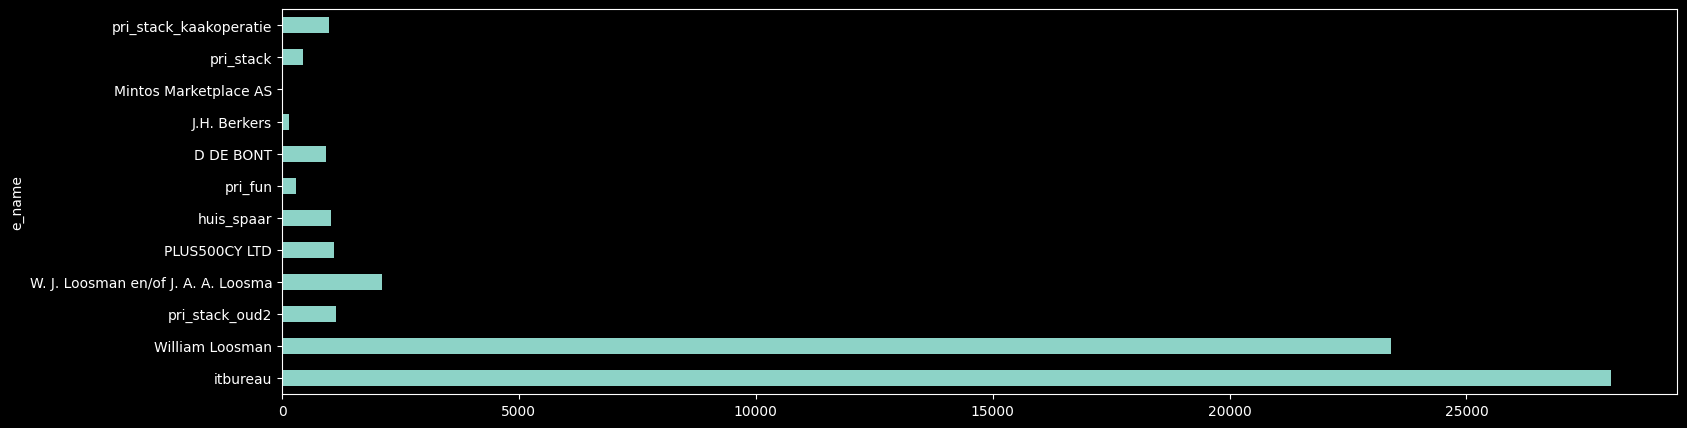

In [93]:
df_per_category = df.groupby(['e_name']) \
                             .agg({'amount': ['count',  'sum', ('per_month', lambda v: v.sum() / 12), 'mean', 'min', 'max']}) \
                             .sort_values(by=[('amount', 'count')], ascending=False)
df_per_category[('amount', 'sum')].plot.barh()
df_per_category

,count,amount
itbureau,21.0,28041.50
William Loosman,11.0,23406.62
pri_stack_oud2,6.0,1143.00
W. J. Loosman en/of J. A. A. Loosma,4.0,2113.70
PLUS500CY LTD,2.0,1099.37
huis_spaar,2.0,1038.81
pri_fun,2.0,300.00
D DE BONT,1.0,924.79
pri_stack,1.0,440.56
pri_stack_kaakoperatie,1.0,1000.02


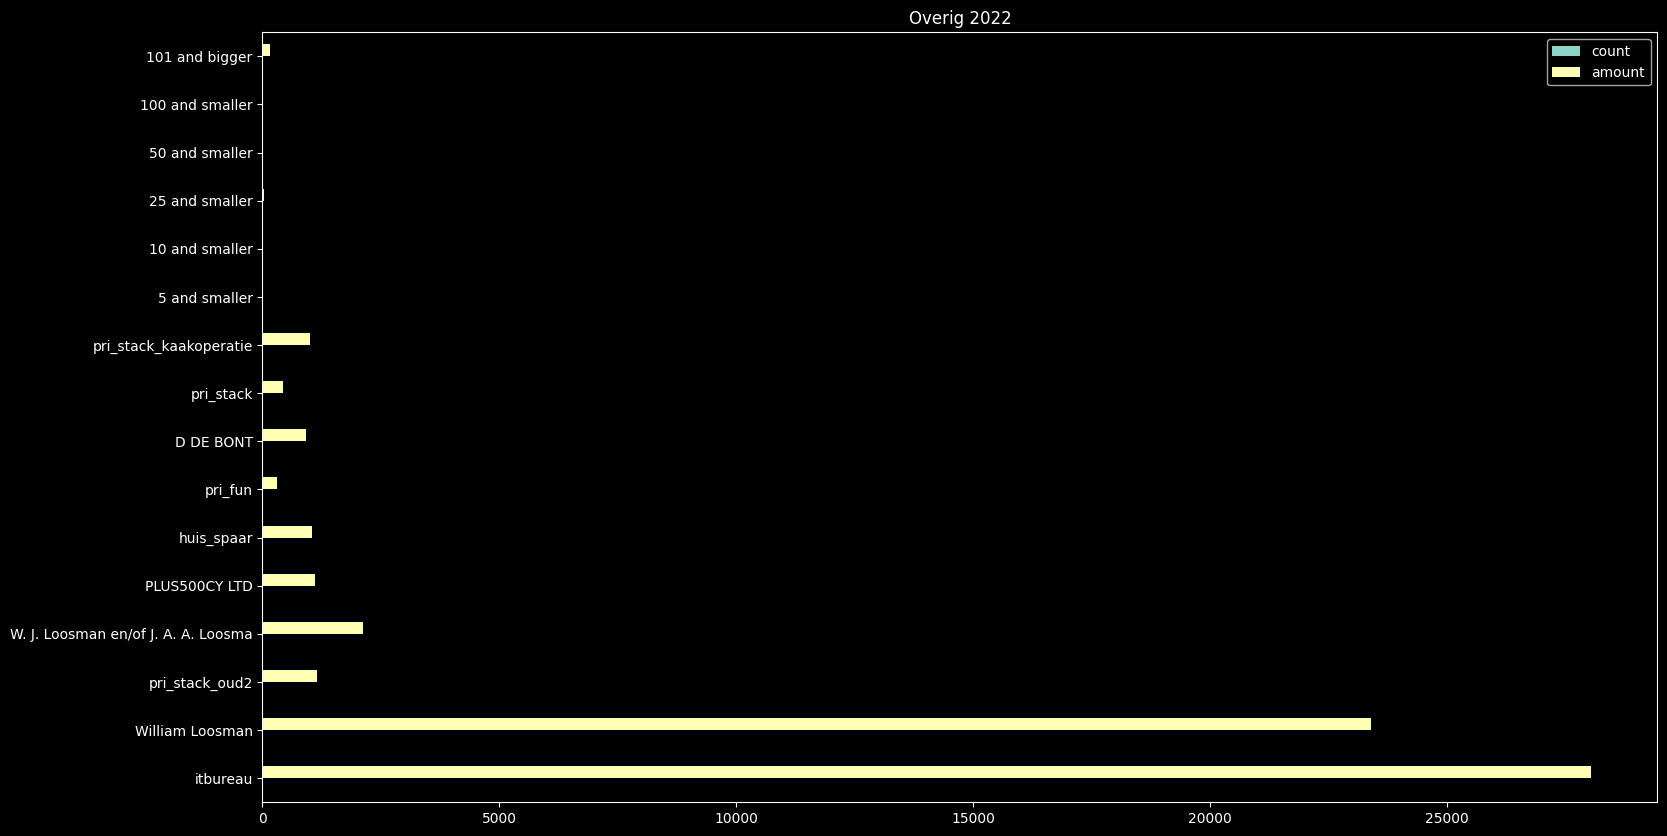

In [94]:
name = []
count = []
amount = []

aggregates = {
    5: [0, 0],
    10: [0, 0],
    25: [0, 0],
    50: [0, 0],
    100: [0, 0],
}
l = list(aggregates)
first_aggregates = l
last_aggregate = l[-1] + 1
aggregates.update({last_aggregate: [0, 0]})

def aggregate_small_values(c):
    n = c.name
    s = c[('amount', 'sum')]
    c = c[('amount', 'count')]

    if c <= 2 and s < 151:

        if s < last_aggregate:
            for a in first_aggregates:
                if s <= a:
                    aggregates[a][0] += c
                    aggregates[a][1] += s
                    break
        else:
            aggregates[last_aggregate][0] += c
            aggregates[last_aggregate][1] += s
    else:
        name.append(n)
        count.append(c)
        amount.append(s)

df_per_category.apply(aggregate_small_values, axis=1)

for a in first_aggregates:
    name.append(f'{a} and smaller')
    count.append(aggregates[a][0])
    amount.append(aggregates[a][1])

name.append(f'{last_aggregate} and bigger')
count.append(aggregates[last_aggregate][0])
amount.append(aggregates[last_aggregate][1])

df_agg = pd.DataFrame(index=name, data={'count': count, 'amount': amount})

plt.rcParams["figure.figsize"] = (18,10)
df_agg.plot.barh(title='Overig ' + year)
plt.rcParams["figure.figsize"] = (18,5)

df_agg

# pin

In [100]:
df = df_pri_overig
df_pin = df[df['payment_type'] == 'Geldautomaat']

b = sum(df_pin['amount'])
pm = round(b / 12, 2)

print('Pin: €', b)
print('P.M.: €', pm)
print('% van I: ', round(pm / 2100 * 100), '%')

df_pin

Pin: € 100.0
P.M.: € 8.33
% van I:  0 %


,date,year,month,credit_or_debet,amount,credit,debet,i_number,i_name,e_number,e_name,internal_or_external,e_type,e_official_name,description,payment_type
48,2022-11-14,2022,11,D,20.0,0.0,20.0,NL55KNAB0604872291,pri_overig,,Geldmaat Passage 65,E,None,Geldmaat Passage 65,Nieuwegein 14-11-2022 14:19 Pas: 0596,Geldautomaat
87,2022-10-03,2022,10,D,20.0,0.0,20.0,NL55KNAB0604872291,pri_overig,,Geldmaat Passage 65,E,None,Geldmaat Passage 65,Nieuwegein 03-10-2022 17:51 Pas: 0596,Geldautomaat
144,2022-07-13,2022,7,D,40.0,0.0,40.0,NL55KNAB0604872291,pri_overig,,Geldmaat Bankstede 1,E,None,Geldmaat Bankstede 1,Nieuwegein 13-07-2022 14:31 Pas: 0596,Geldautomaat
224,2022-04-13,2022,4,D,20.0,0.0,20.0,NL55KNAB0604872291,pri_overig,,Geldmaat Bankstede 1,E,None,Geldmaat Bankstede 1,Nieuwegein 13-04-2022 15:42 Pas: 0596,Geldautomaat


### Boetes!!!

In [68]:
# df_boete = df.loc[df['e_name'] == 'cjib']

search_term = 'cjib'
df_boete = df[df['e_official_name'].str.contains(search_term, na=False, case=False)]

costs = sum(df_boete['amount'])

print("Boetes: €", costs)
print("Per maand: €", round(costs / 12, 2))

df_boete

Boetes: € 1083.0
Per maand: € 90.25


,date,year,month,credit_or_debet,amount,credit,debet,i_number,i_name,e_number,e_name,internal_or_external,e_type,e_official_name,description,payment_type
1,2022-12-28,2022,12,D,332.0,0.0,332.0,NL55KNAB0604872291,pri_overig,NL56INGB0705005100,CJIB Verkeersboetes,E,None,CJIB Verkeersboetes,Betaling via iDEAL QR-code,iDEAL
29,2022-11-28,2022,11,D,238.0,0.0,238.0,NL55KNAB0604872291,pri_overig,NL56INGB0705005100,CJIB Verkeersboetes,E,None,CJIB Verkeersboetes,Betaling via iDEAL QR-code,iDEAL
55,2022-11-07,2022,11,D,259.0,0.0,259.0,NL55KNAB0604872291,pri_overig,NL56INGB0705005100,CJIB Verkeersboetes,E,None,CJIB Verkeersboetes,Betaling via iDEAL QR-code,iDEAL
161,2022-06-20,2022,6,D,53.0,0.0,53.0,NL55KNAB0604872291,pri_overig,NL56INGB0705005100,cjib,E,None,cjib,8062542250256174,Acceptgiro
176,2022-06-07,2022,6,D,42.0,0.0,42.0,NL55KNAB0604872291,pri_overig,NL56INGB0705005100,cjib,E,None,cjib,4062542249895544,Acceptgiro
228,2022-04-06,2022,4,D,159.0,0.0,159.0,NL55KNAB0604872291,pri_overig,NL56INGB0705005100,cjib,E,None,cjib,8062542238908651,Acceptgiro


In [29]:
# df[df['description'].str.contains(search_term, na=False, case=False)]

df_boete = df.loc[df['description'] == '8062542246114392']
df_boete

,date,year,month,credit_or_debet,amount,credit,debet,i_number,i_name,e_number,e_name,internal_or_external,e_type,e_official_name,description,payment_type


## Boodschappen

In [58]:
df = df_pri_boodschappen
df = df.loc[df['credit_or_debet'] == 'D']

print(df['e_name'].value_counts())

df

print(df['amount'].sum())
print(df['amount'].sum() / 12)

Albert Heijn 1327       72
Jumbo Den Bosch Hofv    28
Jumbo Nieuwegein Wal    20
Bakkerij Brouwer        13
Sligro ZB 5060          11
                        ..
SumUp  *Tran Loempia     1
A H Hoogzandveld         1
Kaashandel Dekker        1
CCV*URKER POELIER        1
Jumbo Utrecht Twijns     1
Name: e_name, Length: 74, dtype: int64
4451.77
370.98083333333335


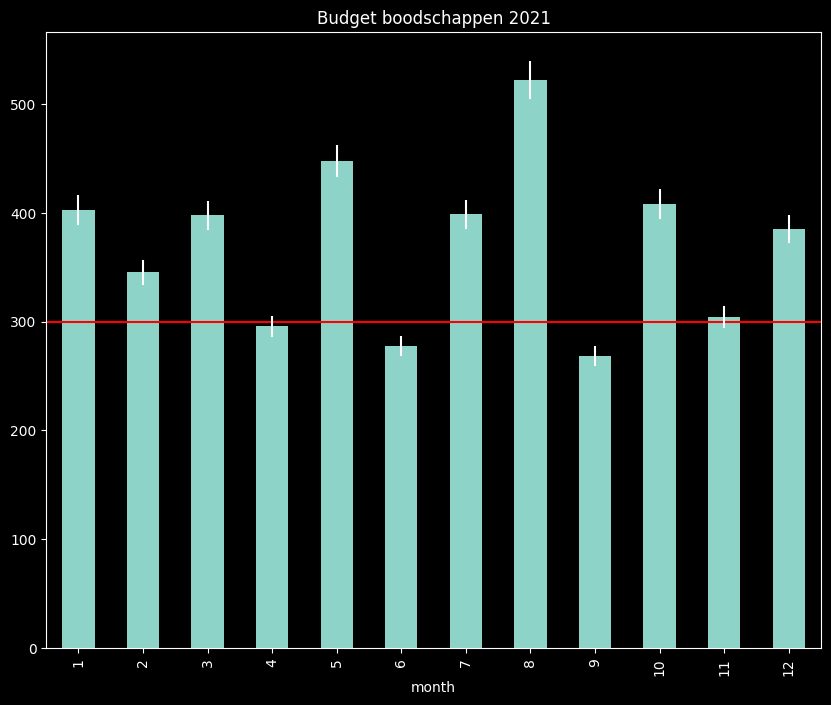

amount                                            
       count     sum    per_day       mean   min     max
month                                                   
1         24  402.55  13.418333  16.772917  4.30  100.00
2         30  345.11  11.503667  11.503667  0.99   35.50
3         21  397.79  13.259667  18.942381  2.14   87.72
4         25  295.48   9.849333  11.819200  0.46   32.20
5         26  447.56  14.918667  17.213846  1.99  126.75
6         16  277.51   9.250333  17.344375  2.23   50.00
7         28  398.57  13.285667  14.234643  1.00   83.40
8         25  521.79  17.393000  20.871600  1.38  130.03
9         20  268.32   8.944000  13.416000  0.65   52.07
10        21  407.87  13.595667  19.422381  4.00   53.67
11        23  303.97  10.132333  13.216087  2.30   34.75
12        17  385.25  12.841667  22.661765  1.50  114.12

In [37]:
budget = 300

df_per_month = df.groupby(['month']) \
                             .agg({'amount': ['count',  'sum', ('per_day', lambda v: v.sum() / 30), 'mean', 'min', 'max']})


%matplotlib inline

fig, axes = plt.subplots(figsize=(10,8))



plt.plot([-1, 12], [budget, budget], color='red')

ax = df_per_month[('amount', 'sum')].plot.bar(ax=axes, yerr=df_per_month[('amount','per_day')], title='Budget boodschappen 2021')

plt.show()

df_per_month

In [32]:
df_per_category = df.groupby(['e_name']) \
                             .agg({'amount': ['count',  'sum', ('per_month', lambda v: v.sum() / 12), 'mean', 'min', 'max']}) \
                             .sort_values(by=[('amount', 'count')], ascending=False)

df_per_category

amount                                 \
                                   count      sum  per_month       mean   
e_name                                                                    
Albert Heijn 1327                     72  1165.57  97.130833  16.188472   
Jumbo Den Bosch Hofv                  28   165.37  13.780833   5.906071   
Jumbo Nieuwegein Wal                  20   268.15  22.345833  13.407500   
Bakkerij Brouwer                      13    94.11   7.842500   7.239231   
Sligro ZB 5060                        11   787.41  65.617500  71.582727   
...                                  ...      ...        ...        ...   
ING Bank NV Betaalverzoek              1    13.50   1.125000  13.500000   
Iper Grandate                          1    27.66   2.305000  27.660000   
5185 Boni Urk                          1     4.57   0.380833   4.570000   
Janssen Fruit                          1     2.35   0.195833   2.350000   
voordeligstedrogist.nl via PAY.nl      1    24.87   2.072500  24.870000   

                                                  
                                     min     max  
e_name                                            
Albert Heijn 1327                   3.52   52.07  
Jumbo Den Bosch Hofv                1.99   10.26  
Jumbo Nieuwegein Wal                0.65   54.77  
Bakkerij Brouwer                    2.64   16.22  
Sligro ZB 5060                     27.78  130.03  
...                                  ...     ...  
ING Bank NV Betaalverzoek          13.50   13.50  
Iper Grandate                      27.66   27.66  
5185 Boni Urk                       4.57    4.57  
Janssen Fruit                       2.35    2.35  
voordeligstedrogist.nl via PAY.nl  24.87   24.87  

[74 rows x 6 columns]

,count,amount
Albert Heijn 1327,72.0,1165.57
Jumbo Den Bosch Hofv,28.0,165.37
Jumbo Nieuwegein Wal,20.0,268.15
Bakkerij Brouwer,13.0,94.11
Sligro ZB 5060,11.0,787.41
AH Urk,9.0,136.11
Albert Heijn 1863,9.0,87.49
Jumbo Nieuwegein LR,8.0,99.73
Poeliersbedr.Verhoef,6.0,135.00
CCV*MAALTIJD PLUS GRIL,4.0,23.74


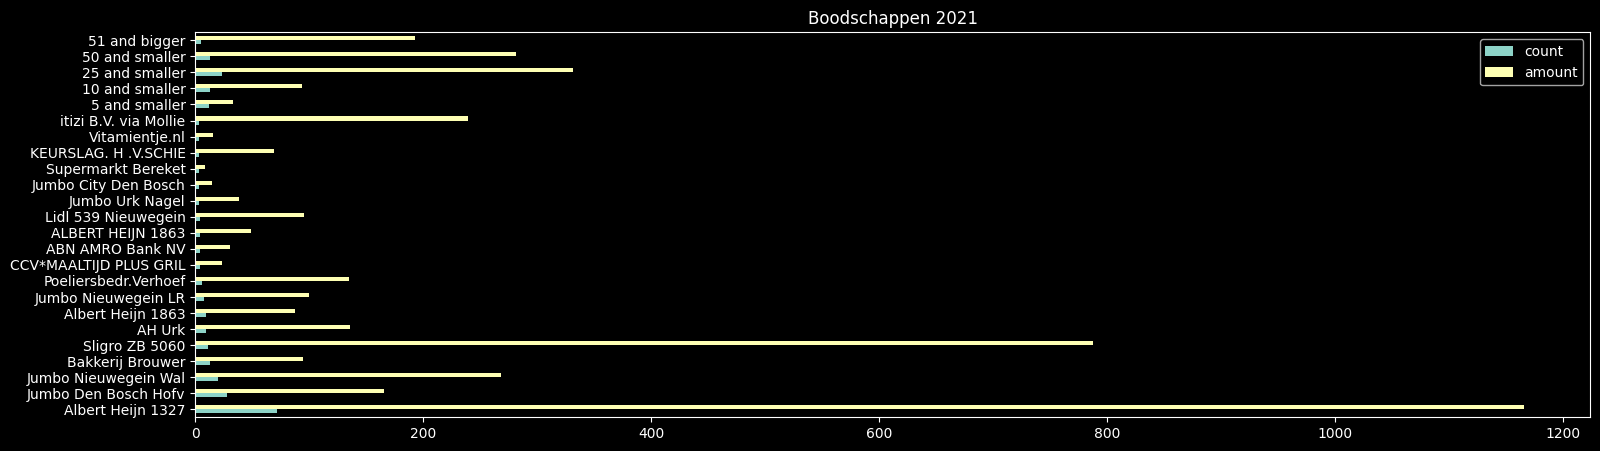

In [33]:
name = []
count = []
amount = []

aggregates = {
    5: [0, 0],
    10: [0, 0],
    25: [0, 0],
    50: [0, 0],
}
l = list(aggregates)
first_aggregates = l
last_aggregate = l[-1] + 1
aggregates.update({last_aggregate: [0, 0]})

def aggregate_small_values(c):
    n = c.name
    s = c[('amount', 'sum')]
    c = c[('amount', 'count')]

    if c <= 2:

        if s < last_aggregate:
            for a in first_aggregates:
                if s <= a:
                    aggregates[a][0] += c
                    aggregates[a][1] += s
                    break
        else:
            aggregates[last_aggregate][0] += c
            aggregates[last_aggregate][1] += s
    else:
        name.append(n)
        count.append(c)
        amount.append(s)

df_per_category.apply(aggregate_small_values, axis=1)

for a in first_aggregates:
    name.append(f'{a} and smaller')
    count.append(aggregates[a][0])
    amount.append(aggregates[a][1])

name.append(f'{last_aggregate} and bigger')
count.append(aggregates[last_aggregate][0])
amount.append(aggregates[last_aggregate][1])

df_agg = pd.DataFrame(index=name, data={'count': count, 'amount': amount})

df_agg.plot.barh(title='Boodschappen 2021')

df_agg

In [54]:
df[df['e_name'].str.lower().str.contains("mollie")]

,date,year,month,credit_or_debet,amount,credit,debet,i_number,i_name,e_number,e_name,internal_or_external,e_type,e_official_name,description,payment_type
239,2022-03-14,2022,3,D,87.72,0.0,87.72,NL60KNAB0604871716,pri_boodschappen,NL51DEUT0265262461,itizi B.V. via Mollie,E,None,itizi B.V. via Mollie,Jimmy Joy NL - .23333039079560,iDEAL
247,2022-03-01,2022,3,D,51.24,0.0,51.24,NL60KNAB0604871716,pri_boodschappen,NL51DEUT0265262461,itizi B.V. via Mollie,E,None,itizi B.V. via Mollie,Jimmy Joy NL - .23180729581704,iDEAL
293,2022-01-20,2022,1,D,100.00,0.0,100.00,NL60KNAB0604871716,pri_boodschappen,NL51DEUT0265262461,itizi B.V. via Mollie,E,None,itizi B.V. via Mollie,Jimmy Joy NL - .22669318029448,iDEAL


## Huis

In [38]:
df = df_huis_inkomen_en_lasten
df = df.loc[df['credit_or_debet'] == 'D']

print(df['e_name'].value_counts())

df

AttributeError: 'NoneType' object has no attribute 'loc'

In [ ]:
budget = 250

df_per_month = df.groupby(['month']) \
                             .agg({'amount': ['count',  'sum', ('per_day', lambda v: v.sum() / 30), 'mean', 'min', 'max']})


%matplotlib inline

fig, axes = plt.subplots(figsize=(10,8))



# plt.plot([-1, 12], [budget, budget], color='red')

ax = df_per_month[('amount', 'sum')].plot.bar(ax=axes, yerr=df_per_month[('amount','per_day')], title='Huis lasten 2021')

plt.show()

df_per_month

In [ ]:
df_per_category = df.groupby(['e_name']) \
                             .agg({'amount': ['count',  'sum', ('per_month', lambda v: v.sum() / 12), 'mean', 'min', 'max']}) \
                             .sort_values(by=[('amount', 'count')], ascending=False)

df_per_category[('amount','sum')].plot.barh(title='Huis lasten 2021')

df_per_category